# Flexible Quantum Circuit Integration with QPIXL

This notebook demonstrates a flexible framework for integrating arbitrary quantum circuits with QPIXL-encoded data circuits. The goal is to provide a modular and extensible way to combine data encoding with quantum algorithms using various strategies like merging, entangling, or slicing circuits.

We will showcase the `CircuitIntegrator` and `QPIXLAlgorithmEncoder` classes, along with helper functions and their application in image and audio processing.

### Step 1: Notebook Title and Initial Setup (Imports)

In [ ]:
import numpy as np
import os
from enum import Enum
from typing import Callable, Dict, List, Optional, Union, Tuple, Any
from itertools import chain

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image
from ipywidgets import interact 

import QPIXL.helper as hlp
from QPIXL.qiskit.qpixl import cFRQI
from QPIXL.qiskit.qpixl_angs import cFRQIangs, decodeAngQPIXL

from QPIXL.qpixl_integrator import (
    CircuitIntegrator, 
    IntegrationMode, 
    QPIXLAlgorithmEncoder, 
    create_pattern_function, 
    create_post_processing
)
from QPIXL.audio_processor import (
    process_audio_with_slices, 
    create_algorithm_circuit
)

import warnings
import soundfile 

warnings.filterwarnings("ignore") 
backend = StatevectorSimulator(method="statevector") 

print("Libraries imported successfully.")

Libraries imported successfully.


### Step 2: Introduction to QPIXL and Baseline Encoding

This step will briefly introduce QPIXL encoding and show a standard image encoding example. This serves as a baseline before we introduce algorithm integration. We'll also define a helper function to run and visualize circuits.

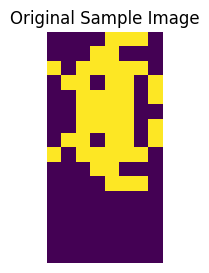

QPIXL-encoded data circuit (30% compression):
- Qubits: 8
- Depth: 204

Visualizing the baseline QPIXL-encoded image:


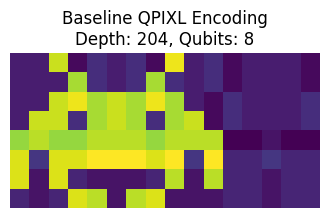

In [2]:
image_data_raw = hlp.examples().space 
image_shape = image_data_raw.shape 

plt.figure(figsize=(3,3))
plt.imshow(image_data_raw)
plt.title("Original Sample Image")
plt.axis('off')
plt.show()


compression_level = 30
data_circuit_qpixl = cFRQI(image_data_raw, compression_level)

print(f"QPIXL-encoded data circuit ({compression_level}% compression):")
print(f"- Qubits: {data_circuit_qpixl.num_qubits}")
print(f"- Depth: {data_circuit_qpixl.depth()}")
data_circuit_qpixl.draw(output='mpl', fold=120, scale=0.7) 


def run_and_show_image(circuit: QuantumCircuit, 
                       original_shape: Tuple[int, int], 
                       title: str = "Decoded Image",
                       ax=None):
    """Runs a quantum circuit, decodes the QPIXL image, and displays it."""
    job = backend.run(circuit)
    statevector = np.real(job.result().get_statevector())
    decoded_image_angles = hlp.decodeQPIXL(statevector) # Using the basic decoder
    reconstructed_image = hlp.reconstruct_img(decoded_image_angles, original_shape).T
    
    if ax is None:
        fig, current_ax = plt.subplots(figsize=(4,4))
    else:
        current_ax = ax
        
    current_ax.imshow(reconstructed_image)
    current_ax.set_title(f"{title}\nDepth: {circuit.depth()}, Qubits: {circuit.num_qubits}")
    current_ax.axis('off')
    
    if ax is None:
        plt.show()
    return reconstructed_image

print("\nVisualizing the baseline QPIXL-encoded image:")
baseline_image = run_and_show_image(data_circuit_qpixl, image_shape, "Baseline QPIXL Encoding")

### Step 3: Define a Sample Algorithm Circuit

We need a simple quantum circuit to represent an "algorithm" that we want to integrate with our QPIXL-encoded data.

Sample Algorithm Circuit:
- Qubits: 3
- Depth: 4


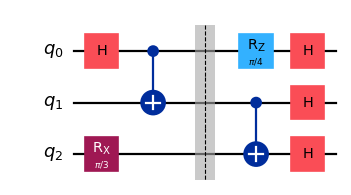

In [3]:
algorithm_qubits = 3
algorithm_circuit = QuantumCircuit(algorithm_qubits, name="Algo")
algorithm_circuit.h(0)
algorithm_circuit.cx(0, 1)
algorithm_circuit.rx(np.pi/3, 2)
algorithm_circuit.barrier()
algorithm_circuit.cx(1, 2)
algorithm_circuit.rz(np.pi/4, 0)
algorithm_circuit.h(range(algorithm_qubits))

print("Sample Algorithm Circuit:")
print(f"- Qubits: {algorithm_circuit.num_qubits}")
print(f"- Depth: {algorithm_circuit.depth()}")
display(algorithm_circuit.draw(output='mpl', scale=0.8))

### Step 4: Introduce `CircuitIntegrator` - Basic Integration Modes (`MERGE`, `ENTANGLE`)

This step will introduce the `CircuitIntegrator` class and demonstrate its basic integration modes: `MERGE` and `ENTANGLE`.

--- MERGE Mode ---
Merged circuit qubits: 11, depth: 205


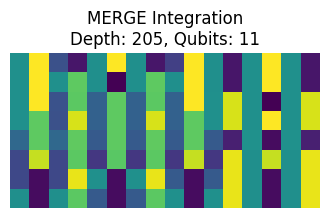


--- ENTANGLE Mode ---
Entangled circuit qubits: 11, depth: 205


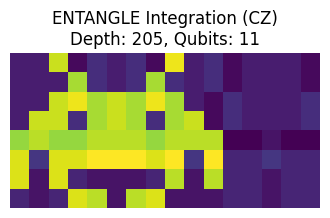


Entangled (SWAP) circuit qubits: 11, depth: 205


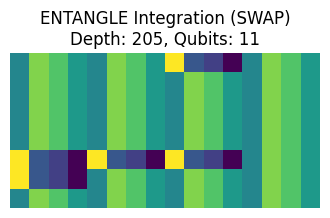

In [4]:
integrator = CircuitIntegrator()

print("--- MERGE Mode ---")
merged_circuit = integrator.integrate(
    data_circuit=data_circuit_qpixl.copy(), 
    algorithm_circuit=algorithm_circuit.copy(),
    mode=IntegrationMode.MERGE,
    connection_map={0: 0, 1: 1}, 
    connection_type='cx' 
)

print(f"Merged circuit qubits: {merged_circuit.num_qubits}, depth: {merged_circuit.depth()}")
merged_circuit.draw(output='mpl', fold=150, scale=0.7) 
merged_image = run_and_show_image(merged_circuit, image_shape, "MERGE Integration")

print("\n--- ENTANGLE Mode ---")
entangled_circuit = integrator.integrate(
    data_circuit=data_circuit_qpixl.copy(),
    algorithm_circuit=algorithm_circuit.copy(),
    mode=IntegrationMode.ENTANGLE,
    connection_map={0: 0, 2: 1}, 
    entangle_type='cz' 
)

print(f"Entangled circuit qubits: {entangled_circuit.num_qubits}, depth: {entangled_circuit.depth()}")
entangled_circuit.draw(output='mpl', fold=150, scale=0.7) 
entangled_image = run_and_show_image(entangled_circuit, image_shape, "ENTANGLE Integration (CZ)")

entangled_swap_circuit = integrator.integrate(
    data_circuit=data_circuit_qpixl.copy(),
    algorithm_circuit=algorithm_circuit.copy(),
    mode=IntegrationMode.ENTANGLE,
    connection_map={i: i for i in range(min(data_circuit_qpixl.num_qubits, algorithm_circuit.num_qubits))}, # Connect corresponding qubits
    entangle_type='swap'
)
print(f"\nEntangled (SWAP) circuit qubits: {entangled_swap_circuit.num_qubits}, depth: {entangled_swap_circuit.depth()}")
entangled_swap_image = run_and_show_image(entangled_swap_circuit, image_shape, "ENTANGLE Integration (SWAP)")

### Step 5: `CircuitIntegrator` - `SLICED` Mode

The `SLICED` mode is more advanced. It breaks the algorithm circuit into smaller pieces (slices) and interleaves them within the data circuit.

--- SLICED Mode ---
Sliced (interval) circuit qubits: 11, depth: 204


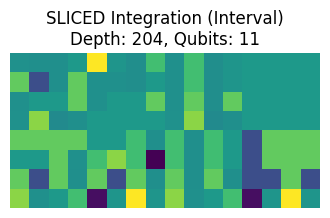


Sliced (end) circuit qubits: 11, depth: 205


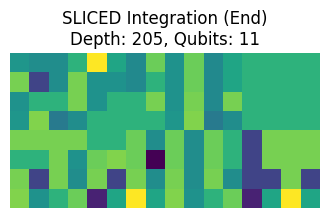

In [5]:
print("--- SLICED Mode ---")

sliced_circuit_interval = integrator.integrate(
    data_circuit=data_circuit_qpixl.copy(),
    algorithm_circuit=algorithm_circuit.copy(),
    mode=IntegrationMode.SLICED,
    slice_size=1,  
    connection_map={0:0, 1:1}, 
    insertion_rule='interval', 
    interval=15, 
    connection_type_within_slice='cx' 
)

print(f"Sliced (interval) circuit qubits: {sliced_circuit_interval.num_qubits}, depth: {sliced_circuit_interval.depth()}")
sliced_circuit_interval.draw(output='mpl', fold=180, scale=0.6) 
sliced_interval_image = run_and_show_image(sliced_circuit_interval, image_shape, "SLICED Integration (Interval)")

sliced_circuit_end = integrator.integrate(
    data_circuit=data_circuit_qpixl.copy(),
    algorithm_circuit=algorithm_circuit.copy(),
    mode=IntegrationMode.SLICED,
    slice_size=2,
    connection_map={0:0},
    insertion_rule='end',
    connection_type_within_slice='cz'
)
print(f"\nSliced (end) circuit qubits: {sliced_circuit_end.num_qubits}, depth: {sliced_circuit_end.depth()}")
sliced_end_image = run_and_show_image(sliced_circuit_end, image_shape, "SLICED Integration (End)")

### Step 6: `CircuitIntegrator` - `CUSTOM` Mode

The `CUSTOM` mode offers maximum flexibility by allowing you to define your own Python function to perform the integration

--- CUSTOM Mode ---
Custom integrated circuit qubits: 11, depth: 206


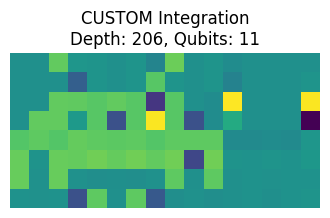

In [6]:
print("--- CUSTOM Mode ---")

def my_custom_integration_rule(data_circ: QuantumCircuit, 
                               algo_circ: QuantumCircuit, 
                               **kwargs) -> QuantumCircuit:
    """
    A custom rule that composes data and algorithm circuits,
    then applies a layer of Hadamard gates to all algorithm qubits,
    and finally adds a CNOT between a specified data qubit and algorithm qubit.
    """
    num_data_qubits = data_circ.num_qubits
    num_algo_qubits = algo_circ.num_qubits
    
    combined_circuit = QuantumCircuit(num_data_qubits + num_algo_qubits, name="CustomIntegrated")
    
    combined_circuit.compose(data_circ, qubits=range(num_data_qubits), inplace=True)
    
    algo_qubit_indices = list(range(num_data_qubits, num_data_qubits + num_algo_qubits))
    combined_circuit.compose(algo_circ, qubits=algo_qubit_indices, inplace=True)
    
    combined_circuit.barrier()
    for q_idx in algo_qubit_indices:
        combined_circuit.h(q_idx)
    combined_circuit.barrier()
        
    data_control_qubit = kwargs.get('data_control', 0)
    algo_target_qubit_offset = kwargs.get('algo_target', 0)
    
    if data_control_qubit < num_data_qubits and algo_target_qubit_offset < num_algo_qubits:
        actual_algo_target = num_data_qubits + algo_target_qubit_offset
        combined_circuit.cx(data_control_qubit, actual_algo_target)
        
    return combined_circuit

custom_integrated_circuit = integrator.integrate(
    data_circuit=data_circuit_qpixl.copy(),
    algorithm_circuit=algorithm_circuit.copy(),
    mode=IntegrationMode.CUSTOM,
    custom_rule=my_custom_integration_rule,
    data_control=1, 
    algo_target=0 
)

print(f"Custom integrated circuit qubits: {custom_integrated_circuit.num_qubits}, depth: {custom_integrated_circuit.depth()}")
custom_integrated_circuit.draw(output='mpl', fold=150, scale=0.7) 
custom_image = run_and_show_image(custom_integrated_circuit, image_shape, "CUSTOM Integration")

### Step 7: Introduce `QPIXLAlgorithmEncoder` - Direct Algorithm Integration

The `QPIXLAlgorithmEncoder` class allows for integrating algorithm operations directly during the QPIXL encoding process. This is different from the `CircuitIntegrator` which combines already existing circuits.

--- QPIXLAlgorithmEncoder: create_circuit ---
Directly integrated circuit qubits: 4, depth: 9


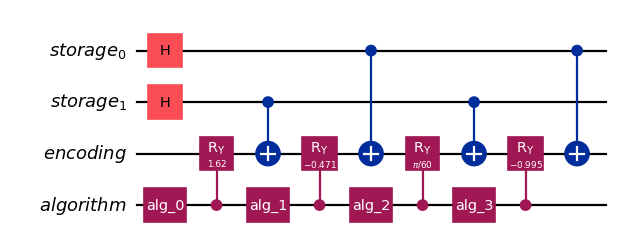


Directly integrated image circuit qubits: 9, depth: 205


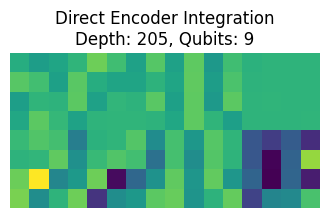

In [7]:
encoder = QPIXLAlgorithmEncoder()

algorithm_ops_config = [
    {'gate': 'unitary', 'params': {'label_prefix': 'custom_U'}}, 
    {'gate': 'cry', 'params': {}}  
]

simple_data_array = np.array([0.1, 0.5, 1.0, 1.5]) 
num_algorithm_qubits_for_encoder = 1 

print("--- QPIXLAlgorithmEncoder: create_circuit ---")
direct_integration_circuit = encoder.create_circuit(
    data=simple_data_array,
    compression=0, 
    algorithm_ops=algorithm_ops_config,
    algorithm_qubits=num_algorithm_qubits_for_encoder
)

print(f"Directly integrated circuit qubits: {direct_integration_circuit.num_qubits}, depth: {direct_integration_circuit.depth()}")
display(direct_integration_circuit.draw(output='mpl', fold=100, scale=0.8))


small_image_data = hlp.examples().space[:16, :16] 
small_image_shape = small_image_data.shape

direct_integration_image_circuit = encoder.create_circuit(
    data=small_image_data, 
    compression=compression_level,
    algorithm_ops=algorithm_ops_config,
    algorithm_qubits=num_algorithm_qubits_for_encoder
)

print(f"\nDirectly integrated image circuit qubits: {direct_integration_image_circuit.num_qubits}, depth: {direct_integration_image_circuit.depth()}")
direct_integration_image = run_and_show_image(direct_integration_image_circuit, small_image_shape, "Direct Encoder Integration")

### Step 8: `QPIXLAlgorithmEncoder` - `create_sliced_circuit` Method

This method of the `QPIXLAlgorithmEncoder` is specifically designed to integrate an existing algorithm circuit by slicing it and interleaving it during the QPIXL encoding of data.

--- QPIXLAlgorithmEncoder: create_sliced_circuit ---
Encoder-sliced circuit qubits: 11, depth: 211


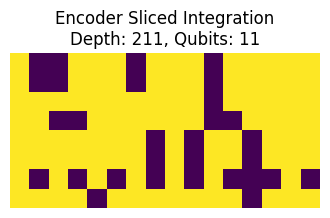

In [8]:
print("--- QPIXLAlgorithmEncoder: create_sliced_circuit ---")

if algorithm_circuit.num_qubits != 3: 
    algorithm_circuit_for_slicing = QuantumCircuit(3, name="AlgoSlice")
    algorithm_circuit_for_slicing.h(0)
    algorithm_circuit_for_slicing.cx(0,1)
    algorithm_circuit_for_slicing.rz(np.pi/2, 2)
else:
    algorithm_circuit_for_slicing = algorithm_circuit.copy()


encoder_sliced_circuit = encoder.create_sliced_circuit(
    data=image_data_raw, 
    algorithm_circuit=algorithm_circuit_for_slicing,
    compression=compression_level,
    slice_size=1,  
    insertion_rule='interval',
    interval=20,   
    connection_rule='cx', 
    connection_map = {0:0}, 
    algorithm_qubits=algorithm_circuit_for_slicing.num_qubits 
)

print(f"Encoder-sliced circuit qubits: {encoder_sliced_circuit.num_qubits}, depth: {encoder_sliced_circuit.depth()}")
encoder_sliced_circuit.draw(output='mpl', fold=200, scale=0.5) 
encoder_sliced_image = run_and_show_image(encoder_sliced_circuit, image_shape, "Encoder Sliced Integration")

### Step 9: Helper Functions - `create_pattern_function` and `create_post_processing`

These utility functions help define reusable patterns or sequences of gates that can be incorporated into the encoding process.

--- Helper: create_pattern_function ---
Dummy circuit with CRX pattern:


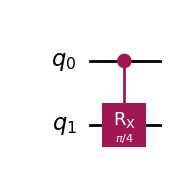


--- Helper: create_post_processing ---
Encoder circuit with post-processing qubits: 10, depth: 205


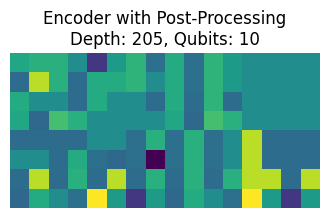

In [11]:
print("--- Helper: create_pattern_function ---")

crx_pattern_func, crx_angle = create_pattern_function(
    gate_name='crx', 
    angle=np.pi/4, 
    control=0, 
    target=1   
)
dummy_qc_pattern = QuantumCircuit(2)
crx_pattern_func(dummy_qc_pattern) 
print("Dummy circuit with CRX pattern:")
display(dummy_qc_pattern.draw(output='mpl'))


print("\n--- Helper: create_post_processing ---")
post_processing_ops_config = [
    {'gate': 'h', 'qubits': [0]}, 
    {'gate': 'rx', 'qubits': [1], 'params': {'angle': np.pi/6}} 
]


post_processing_callable = create_post_processing(post_processing_ops_config)

def get_max_qubit_index_from_op_list(op_list: List[Dict]) -> int:
    """
    Calculates the maximum qubit index referenced in a list of operations.
    Each operation is a dict and should have a 'qubits' key (a list of ints).
    """
    max_idx = -1
    if not op_list:
        return 0 
    for op in op_list:
        if 'qubits' in op and op['qubits']:
            current_max = max(op['qubits'])
            if current_max > max_idx:
                max_idx = current_max
    return max_idx

if post_processing_ops_config:
    max_qubit_idx_post_proc = get_max_qubit_index_from_op_list(post_processing_ops_config)
    num_algo_qubits_for_post_proc = max_qubit_idx_post_proc + 1
else:
    num_algo_qubits_for_post_proc = 1 


encoder_with_post_proc_circuit = encoder.create_circuit(
    data=small_image_data, 
    compression=compression_level,
    algorithm_ops=[], 
    algorithm_qubits=num_algo_qubits_for_post_proc,
    post_processing=post_processing_callable 
)

print(f"Encoder circuit with post-processing qubits: {encoder_with_post_proc_circuit.num_qubits}, depth: {encoder_with_post_proc_circuit.depth()}")
encoder_with_post_proc_circuit.draw(output='mpl', fold=150, scale=0.7) 
post_proc_image = run_and_show_image(encoder_with_post_proc_circuit, small_image_shape, "Encoder with Post-Processing")


### Step 10: Application - Visual Effects on Images

This step will demonstrate how to use the `CircuitIntegrator` (particularly `CUSTOM` or `ENTANGLE` modes) to create visual effects by combining QPIXL circuits of two different images.

In [ ]:
img1_raw = hlp.examples().invader
shape1 = img1_raw.shape
img2_raw = hlp.examples().space 
shape2 = img2_raw.shape 

print("--- Visual Effects Demo ---")

def interactive_image_integration(angle_param:float=np.pi/4, 
                                  gate_type:str="CRX", 
                                  compression1:int=30, 
                                  compression2:int=30,
                                  num_connecting_qubits:int=4):
    
    qpixl_circuit1 = cFRQI(img1_raw.copy(), compression1)
    qpixl_circuit2 = cFRQI(img2_raw.copy(), compression2)


    num_address_qubits1 = qpixl_circuit1.num_qubits - 1 
    num_address_qubits2 = qpixl_circuit2.num_qubits - 1
    
    connect_limit = min(num_address_qubits1, num_address_qubits2, num_connecting_qubits)

    if connect_limit <= 0:
        print("Cannot connect qubits, check compression or num_connecting_qubits.")
        run_and_show_image(qpixl_circuit1, shape1, f"Original Image 1 (No Connection)")
        return

    integrator_imgs = CircuitIntegrator()
    integrated_img_qc = None

    if gate_type == "CRX" or gate_type == "CRY":
        def custom_rot_rule(data_circ1, data_circ2, **kwargs):
            g_type = kwargs.get('gate', 'crx')
            ang = kwargs.get('angle', 0)
            limit = kwargs.get('limit', 1)
            
            combined_qc = QuantumCircuit(data_circ1.num_qubits + data_circ2.num_qubits)
            combined_qc.compose(data_circ1, qubits=range(data_circ1.num_qubits), inplace=True)
            combined_qc.compose(data_circ2, qubits=range(data_circ1.num_qubits, combined_qc.num_qubits), inplace=True)
            
            combined_qc.barrier()
            for i in range(limit): 
                q_control = i 
                q_target = data_circ1.num_qubits + i 
                if g_type == 'crx':
                    combined_qc.crx(ang, q_control, q_target)
                elif g_type == 'cry':
                    combined_qc.cry(ang, q_control, q_target)
            combined_qc.barrier()
            return combined_qc
        
        integrated_img_qc = integrator_imgs.integrate(
            qpixl_circuit1, qpixl_circuit2,
            mode=IntegrationMode.CUSTOM,
            custom_rule=custom_rot_rule,
            gate=gate_type.lower(),
            angle=angle_param,
            limit=connect_limit
        )
    elif gate_type == "SWAP":
        connection_map_swap = {i: i for i in range(connect_limit)}
        integrated_img_qc = integrator_imgs.integrate(
            qpixl_circuit1, qpixl_circuit2,
            mode=IntegrationMode.ENTANGLE,
            connection_map=connection_map_swap,
            entangle_type='swap'
        )
    elif gate_type == "CX":
        connection_map_cx = {i: i for i in range(connect_limit)}
        integrated_img_qc = integrator_imgs.integrate(
            qpixl_circuit1, qpixl_circuit2,
            mode=IntegrationMode.ENTANGLE,
            connection_map=connection_map_cx,
            entangle_type='cx' 
        )
    else:
        print(f"Gate type {gate_type} not recognized for this demo. Showing original image 1.")
        run_and_show_image(qpixl_circuit1, shape1, f"Original Image 1 (Unrecognized Gate)")
        return

    print(f"Integrated with {gate_type}, angle: {angle_param if 'CR' in gate_type else 'N/A'}, connections: {connect_limit}")
    run_and_show_image(integrated_img_qc, shape1, f"Visual Effect: {gate_type}")

interact(
    interactive_image_integration,
    angle_param=(0, 2 * np.pi, 0.1),
    gate_type=["CRX", "CRY", "SWAP", "CX"],
    compression1=(0, 95, 5),
    compression2=(0, 95, 5),
    num_connecting_qubits=(1, min(hlp.ilog2(img1_raw.size), hlp.ilog2(img2_raw.size)) -1 , 1) # Max based on smaller image dimension
);

--- Visual Effects Demo ---


interactive(children=(FloatSlider(value=0.7853981633974483, description='angle_param', max=6.283185307179586),…

--- Creating Algorithm Circuits for Audio ---
Sample QFT Algorithm Circuit (for audio):


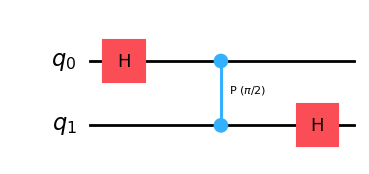


Sample Custom Algorithm Circuit (for audio):


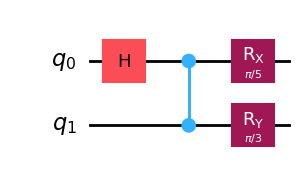


--- Demonstrating `process_audio_with_slices` ---
The following shows how to call `process_audio_with_slices`.

Attempting to process: Sample_Material/underground.mp3
Output will be in: Sample_Material/underground
Audio processing finished for QFT. Check Sample_Material/underground
Audio processing finished for Custom Algo. Check Sample_Material/underground


In [15]:
print("--- Creating Algorithm Circuits for Audio ---")
qft_algorithm_audio = create_algorithm_circuit(
    circuit_type='qft', 
    num_qubits=2 
)
print("Sample QFT Algorithm Circuit (for audio):")
display(qft_algorithm_audio.draw(output='mpl'))

custom_algo_audio = QuantumCircuit(2, name="CustomAudioAlgo")
custom_algo_audio.h(0)
custom_algo_audio.cz(0,1)
custom_algo_audio.rx(np.pi/5, 0)
custom_algo_audio.ry(np.pi/3, 1)
print("\nSample Custom Algorithm Circuit (for audio):")
display(custom_algo_audio.draw(output='mpl'))


print("\n--- Demonstrating `process_audio_with_slices` ---")
print("The following shows how to call `process_audio_with_slices`.")

example_input_audio_file = "Sample_Material/underground.mp3"
example_output_directory = "Sample_Material/underground"

os.makedirs(example_output_directory, exist_ok=True)


audio_connection_map = {0: 0, 1: 1} 

print(f"\nAttempting to process: {example_input_audio_file}")
print(f"Output will be in: {example_output_directory}")

if os.path.exists(example_input_audio_file):
    try:
        process_audio_with_slices(
            input_file=example_input_audio_file,
            output_dir=example_output_directory,
            algorithm_circuit=qft_algorithm_audio, 
            slice_size=1,                           
            insertion_rule='interval',              
            interval=10,                           
            connection_rule='cx',                   
            connection_map=audio_connection_map,
            compression=10,                         
            tag="qft_integrated_demo"               
        )
        print(f"Audio processing finished for QFT. Check {example_output_directory}")

        process_audio_with_slices(
            input_file=example_input_audio_file,
            output_dir=example_output_directory,
            algorithm_circuit=custom_algo_audio, 
            slice_size=1,
            insertion_rule='interval',
            interval=8,
            connection_rule='cz',
            connection_map=audio_connection_map,
            compression=10,
            tag="custom_algo_integrated_demo"
        )
        print(f"Audio processing finished for Custom Algo. Check {example_output_directory}")

    except Exception as e:
        print(f"An error occurred during audio processing: {e}")
        print("Please ensure 'ffmpeg' is installed and accessible in your system PATH if not using wav.")
        print("Also, verify the input audio file format and integrity.")
else:
    print(f"\nSkipping audio processing example as '{example_input_audio_file}' not found.")
    print("Please set 'example_input_audio_file' to a valid audio file path to run this.")




## Summary of Demonstrated Capabilities

This notebook has demonstrated a flexible framework for integrating quantum algorithms
with QPIXL-encoded data (images and audio). Key components and functionalities showcased include:

1.  **`CircuitIntegrator` Class:**
    *   **`MERGE` Mode:** Combining data and algorithm circuits side-by-side with optional connections.
    *   **`ENTANGLE` Mode:** Connecting circuits using specified entangling operations (e.g., CX, CZ, SWAP).
    *   **`SLICED` Mode:** Breaking an algorithm circuit into smaller slices and interleaving them within a data circuit based on rules like 'interval' or 'end'.
    *   **`CUSTOM` Mode:** Allowing users to define their own Python functions for bespoke integration logic, offering maximum flexibility.

2.  **`QPIXLAlgorithmEncoder` Class:**
    *   **`create_circuit` Method:** Directly embedding algorithm operations (defined via `algorithm_ops`) into the QPIXL encoding process on a per-data-point basis. It also supports `post_processing` steps.
    *   **`create_sliced_circuit` Method:** Integrating an existing algorithm circuit by slicing it and interleaving these slices during the QPIXL encoding of data, with specified connection rules.

3.  **Helper Functions:**
    *   `create_pattern_function`: For defining reusable circuit patterns (often used with older functions like `cFRQIangs` or as components in custom rules).
    *   `create_post_processing`: For defining a sequence of operations to be applied after the main encoding and integration.
    *   `create_algorithm_circuit`: For easily generating standard algorithm circuits (e.g., QFT, QAOA) for use in integration.

4.  **Applications:**
    *   **Image Processing:** Demonstrated interactive visual effects by combining QPIXL encodings of two images using various integration strategies.
    *   **Audio Processing:** Showcased how `process_audio_with_slices` can be used to integrate sliced algorithm circuits into the QPIXL encoding of audio chunks, enabling quantum-enhanced audio manipulation.

## Benefits of this Framework

*   **Modularity:** Separates data encoding logic from algorithm logic and integration strategy.
*   **Extensibility:** Easily add new integration rules or algorithm components.
*   **Flexibility:** Supports various ways to combine circuits, from simple appending to complex interleaving.
*   **Experimentation:** Facilitates rapid prototyping and testing of different quantum data processing pipelines.
*   **Clarity:** Provides a structured approach to building complex quantum circuits for data-driven tasks.

## Future Directions

This framework can be extended further by:
*   Adding more predefined integration modes or algorithm components.
*   Integrating with quantum machine learning libraries.
*   Optimizing circuit compositions for specific hardware backends.
*   Developing more sophisticated rules for slicing and insertion based on circuit properties.